In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import pickle
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)

print("🎯 ULTIMATE 85%+ CRICKET MATCH PREDICTOR")
print("="*70)

matches = pd.read_csv('../data/processed/quality_matches_dataset.csv')

print(f"\n✅ Loaded {len(matches)} quality matches")
print(f"📊 Formats: {dict(matches['match_format'].value_counts())}")
print(f"🌍 Venues: {matches['venue'].nunique()}")
print(f"🏏 Teams: {pd.concat([matches['team1'], matches['team2']]).nunique()}")

matches.head()

🎯 ULTIMATE 85%+ CRICKET MATCH PREDICTOR

✅ Loaded 7513 quality matches
📊 Formats: {'T20': np.int64(3599), 'ODI': np.int64(2778), 'IPL': np.int64(1136)}
🌍 Venues: 557
🏏 Teams: 125


,match_format,venue,season,team1,team2,team1_runs,team1_wickets,team1_run_rate,team1_boundaries,team1_fours,team1_sixes,team2_runs,team2_wickets,team2_run_rate,team2_boundaries,team2_fours,team2_sixes,run_difference,team1_won,winner
0,T20,Melbourne Cricket Ground,2016/17,Australia,Sri Lanka,168,6,8.06,13,9,4,172,5,8.26,21,20,1,4,0,Sri Lanka
1,T20,"Simonds Stadium, South Geelong",2016/17,Australia,Sri Lanka,173,10,8.44,16,10,6,176,8,8.52,24,18,6,3,0,Sri Lanka
2,T20,Adelaide Oval,2016/17,Australia,Sri Lanka,187,6,8.98,22,14,8,146,10,7.62,17,12,5,41,1,Australia
3,T20,"Bready Cricket Club, Magheramason",2016,Hong Kong,Ireland,169,5,7.92,18,13,5,129,10,6.40,14,12,2,40,1,Hong Kong
4,T20,Harare Sports Club,2016,Zimbabwe,India,170,7,8.23,21,11,10,168,6,7.81,19,13,6,2,1,Zimbabwe


In [4]:
print("🔧 Engineering ADVANCED Features for 85%+ Accuracy...")
print("="*70)

# 1. TEAM HISTORICAL PERFORMANCE
print("\n1️⃣ Calculating team historical performance...")
team_stats = {}

for team in pd.concat([matches['team1'], matches['team2']]).unique():
    t1_matches = matches[matches['team1'] == team]
    t2_matches = matches[matches['team2'] == team]
    
    # Overall stats
    total_matches = len(t1_matches) + len(t2_matches)
    if total_matches == 0:
        continue
    
    # Wins
    wins_as_t1 = t1_matches['team1_won'].sum()
    wins_as_t2 = len(t2_matches) - t2_matches['team1_won'].sum()
    total_wins = wins_as_t1 + wins_as_t2
    
    # Win rates
    overall_wr = total_wins / total_matches
    bat_first_wr = wins_as_t1 / len(t1_matches) if len(t1_matches) > 0 else 0.5
    chase_wr = wins_as_t2 / len(t2_matches) if len(t2_matches) > 0 else 0.5
    
    # Scoring stats
    avg_score = t1_matches['team1_runs'].mean() if len(t1_matches) > 0 else 150
    avg_rr = t1_matches['team1_run_rate'].mean() if len(t1_matches) > 0 else 6.0
    avg_boundaries = t1_matches['team1_boundaries'].mean() if len(t1_matches) > 0 else 15
    
    team_stats[team] = {
        'overall_win_rate': overall_wr,
        'bat_first_win_rate': bat_first_wr,
        'chase_win_rate': chase_wr,
        'avg_score': avg_score,
        'avg_run_rate': avg_rr,
        'avg_boundaries': avg_boundaries,
        'total_matches': total_matches
    }

# Add team stats to matches
matches['team1_overall_wr'] = matches['team1'].map(lambda x: team_stats.get(x, {}).get('overall_win_rate', 0.5))
matches['team2_overall_wr'] = matches['team2'].map(lambda x: team_stats.get(x, {}).get('overall_win_rate', 0.5))
matches['team1_bat_first_wr'] = matches['team1'].map(lambda x: team_stats.get(x, {}).get('bat_first_win_rate', 0.5))
matches['team2_chase_wr'] = matches['team2'].map(lambda x: team_stats.get(x, {}).get('chase_win_rate', 0.5))
matches['team1_avg_score'] = matches['team1'].map(lambda x: team_stats.get(x, {}).get('avg_score', 150))
matches['team1_avg_rr'] = matches['team1'].map(lambda x: team_stats.get(x, {}).get('avg_run_rate', 6.0))

print(f"   ✅ Calculated stats for {len(team_stats)} teams")

# 2. VENUE INTELLIGENCE (GROUND-SPECIFIC STATS!)
print("\n2️⃣ Calculating venue-specific statistics...")
venue_stats = matches.groupby('venue').agg({
    'team1_runs': ['mean', 'std', 'median'],
    'team1_won': 'mean',
    'team1_run_rate': 'mean',
    'team1_boundaries': 'mean',
    'team1_wickets': 'mean',
    'venue': 'count'
}).reset_index()

venue_stats.columns = ['venue', 'venue_avg_score', 'venue_score_std', 'venue_median_score',
                       'venue_bat_first_advantage', 'venue_avg_rr', 'venue_avg_boundaries',
                       'venue_avg_wickets', 'venue_match_count']

# Merge venue stats
matches = matches.merge(venue_stats, on='venue', how='left')

# Fill missing values with dataset averages
matches['venue_avg_score'].fillna(matches['team1_runs'].mean(), inplace=True)
matches['venue_bat_first_advantage'].fillna(0.5, inplace=True)
matches['venue_avg_rr'].fillna(matches['team1_run_rate'].mean(), inplace=True)
matches['venue_avg_boundaries'].fillna(matches['team1_boundaries'].mean(), inplace=True)

print(f"   ✅ Analyzed {matches['venue'].nunique()} unique venues")

# 3. HEAD-TO-HEAD RECORDS
print("\n3️⃣ Calculating head-to-head records...")
h2h_stats = {}

for idx, row in matches.iterrows():
    t1, t2 = row['team1'], row['team2']
    key = tuple(sorted([t1, t2]))
    
    if key not in h2h_stats:
        h2h_matches = matches[
            ((matches['team1'] == t1) & (matches['team2'] == t2)) |
            ((matches['team1'] == t2) & (matches['team2'] == t1))
        ]
        
        t1_wins = len(h2h_matches[
            ((h2h_matches['team1'] == t1) & (h2h_matches['team1_won'] == 1)) |
            ((h2h_matches['team2'] == t1) & (h2h_matches['team1_won'] == 0))
        ])
        
        total = len(h2h_matches)
        h2h_stats[key] = t1_wins / total if total > 0 else 0.5

matches['h2h_advantage'] = matches.apply(
    lambda row: h2h_stats.get(tuple(sorted([row['team1'], row['team2']])), 0.5), 
    axis=1
)

print(f"   ✅ Calculated {len(h2h_stats)} head-to-head matchups")

# 4. DERIVED FEATURES
print("\n4️⃣ Creating derived features...")

# Score comparison
matches['score_vs_venue_avg'] = matches['team1_runs'] - matches['venue_avg_score']
matches['score_vs_team_avg'] = matches['team1_runs'] - matches['team1_avg_score']
matches['rr_vs_venue_avg'] = matches['team1_run_rate'] - matches['venue_avg_rr']

# Boundaries analysis
matches['boundaries_vs_venue'] = matches['team1_boundaries'] - matches['venue_avg_boundaries']
matches['boundary_rate'] = matches['team1_boundaries'] / matches['team1_runs'] * 100

# Team strength difference
matches['team_strength_diff'] = matches['team1_overall_wr'] - matches['team2_overall_wr']
matches['match_advantage'] = (matches['team1_bat_first_wr'] - matches['team2_chase_wr']) * 100

# Wickets analysis
matches['wickets_in_hand'] = 10 - matches['team1_wickets']
matches['wickets_lost_rate'] = matches['team1_wickets'] / matches['team1_runs'] * 100

# Run rate quality
matches['rr_quality'] = matches['team1_run_rate'] - matches['team1_avg_rr']
matches['rr_vs_par'] = matches['team1_run_rate'] - 7.0  # 7 is par for T20

# Venue adaptation
matches['venue_adaptation'] = abs(matches['score_vs_venue_avg']) / matches['venue_score_std'].fillna(20)

# Pressure handling (close matches)
matches['close_match'] = (matches['run_difference'] < 30).astype(int)

# Format-specific normalization
matches['normalized_score'] = matches.apply(
    lambda x: x['team1_runs'] / 200 if x['match_format'] == 'ODI' else x['team1_runs'] / 160,
    axis=1
)

print("   ✅ Created 20+ derived features")

print("\n✅ FEATURE ENGINEERING COMPLETE!")
print(f"📊 Total columns: {len(matches.columns)}")

🔧 Engineering ADVANCED Features for 85%+ Accuracy...

1️⃣ Calculating team historical performance...
   ✅ Calculated stats for 125 teams

2️⃣ Calculating venue-specific statistics...
   ✅ Analyzed 557 unique venues

3️⃣ Calculating head-to-head records...
   ✅ Calculated 870 head-to-head matchups

4️⃣ Creating derived features...
   ✅ Created 20+ derived features

✅ FEATURE ENGINEERING COMPLETE!
📊 Total columns: 49


In [5]:
# Select features based on SIMPLE USER INPUTS:
# User provides: runs, wickets, run_rate, team names, venue

features = [
    # USER INPUT FEATURES (what user provides)
    'team1_runs',                    # ✓ User provides
    'team1_wickets',                 # ✓ User provides  
    'team1_run_rate',                # ✓ User provides
    
    # TEAM STRENGTH (from database based on team names)
    'team1_overall_wr',              # From team history
    'team2_overall_wr',              # From team history
    'team1_bat_first_wr',            # From team history
    'team2_chase_wr',                # From team history
    'team_strength_diff',            # Calculated
    'h2h_advantage',                 # From head-to-head
    
    # VENUE STATS (from database based on ground selected)
    'venue_avg_score',               # From venue database
    'venue_bat_first_advantage',     # From venue database
    'venue_avg_rr',                  # From venue database
    'venue_avg_boundaries',          # From venue database
    
    # CALCULATED FROM USER INPUT
    'team1_boundaries',              # Estimate from score
    'score_vs_venue_avg',            # team1_runs - venue_avg_score
    'rr_vs_venue_avg',               # team1_rr - venue_avg_rr
    'wickets_in_hand',               # 10 - team1_wickets
    'rr_quality',                    # Compare to team average
    'normalized_score'               # Score normalized by format
]

X = matches[features].fillna(0)
y = matches['team1_won']

print(f"✅ Selected {len(features)} features")
print(f"✅ Dataset: {len(X)} matches")
print(f"\n📊 Feature Categories:")
print(f"   🎯 User Input Features: 3 (runs, wickets, run_rate)")
print(f"   🏏 Team Strength Features: 6")
print(f"   🌍 Venue Features: 4")
print(f"   🔢 Calculated Features: 7")

print(f"\n🎯 Target Balance:")
print(f"   Team 1 Wins (Batting First): {y.sum()} ({y.mean()*100:.1f}%)")
print(f"   Team 2 Wins (Chasing): {len(y)-y.sum()} ({(1-y.mean())*100:.1f}%)")

✅ Selected 19 features
✅ Dataset: 7513 matches

📊 Feature Categories:
   🎯 User Input Features: 3 (runs, wickets, run_rate)
   🏏 Team Strength Features: 6
   🌍 Venue Features: 4
   🔢 Calculated Features: 7

🎯 Target Balance:
   Team 1 Wins (Batting First): 3687 (49.1%)
   Team 2 Wins (Chasing): 3826 (50.9%)


In [6]:
# Split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

print(f"📊 Training: {len(X_train)} | Testing: {len(X_test)}")
print("\n🤖 Training ADVANCED ENSEMBLE MODEL...")
print("="*70)

# Model 1: Random Forest (Optimized)
rf = RandomForestClassifier(
    n_estimators=600,
    max_depth=25,
    min_samples_split=3,
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Model 2: XGBoost (Optimized)
xgb = XGBClassifier(
    n_estimators=600,
    max_depth=20,
    learning_rate=0.03,
    subsample=0.85,
    colsample_bytree=0.85,
    gamma=0.1,
    scale_pos_weight=1,
    random_state=42,
    n_jobs=-1
)

# Model 3: Gradient Boosting (Optimized)
gb = GradientBoostingClassifier(
    n_estimators=500,
    max_depth=15,
    learning_rate=0.03,
    subsample=0.85,
    random_state=42
)

# Model 4: AdaBoost
ada = AdaBoostClassifier(
    n_estimators=300,
    learning_rate=0.5,
    random_state=42
)

# SUPER ENSEMBLE - Voting Classifier
print("\n🔥 Creating SUPER ENSEMBLE with 4 algorithms...")
ensemble = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('xgb', xgb),
        ('gb', gb),
        ('ada', ada)
    ],
    voting='soft',
    weights=[2, 2, 1, 1],  # RF and XGB get more weight
    n_jobs=-1
)

print("⏳ Training ensemble (this may take 2-3 minutes)...")
ensemble.fit(X_train, y_train)

# Predictions
y_pred = ensemble.predict(X_test)
y_pred_proba = ensemble.predict_proba(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba[:, 1])

print("\n" + "="*70)
print("🏆 FINAL MODEL PERFORMANCE:")
print("="*70)
print(f"🎯 ACCURACY: {accuracy*100:.2f}%")
print(f"📊 AUC-ROC Score: {auc:.4f}")

if accuracy >= 0.85:
    print("\n🎉🎉🎉 ACHIEVED 85%+ ACCURACY! 🎉🎉🎉")
elif accuracy >= 0.80:
    print("\n✅ Excellent! 80%+ Accuracy Achieved!")
elif accuracy >= 0.75:
    print("\n👍 Good! 75%+ Accuracy - Close to target!")
else:
    print(f"\n⚠️ Current: {accuracy*100:.1f}% - Need more data/features")

print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORT:")
print("="*70)
print(classification_report(y_test, y_pred, 
                          target_names=['Team 2 Wins (Chase)', 'Team 1 Wins (Defend)']))

# Test individual models
print("\n" + "="*70)
print("INDIVIDUAL MODEL PERFORMANCE:")
print("="*70)

for name, model in [('Random Forest', rf), ('XGBoost', xgb), 
                     ('Gradient Boosting', gb), ('AdaBoost', ada)]:
    model.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    print(f"{name:20s}: {acc*100:.2f}%")

📊 Training: 6386 | Testing: 1127

🤖 Training ADVANCED ENSEMBLE MODEL...

🔥 Creating SUPER ENSEMBLE with 4 algorithms...
⏳ Training ensemble (this may take 2-3 minutes)...

🏆 FINAL MODEL PERFORMANCE:
🎯 ACCURACY: 74.27%
📊 AUC-ROC Score: 0.8303

⚠️ Current: 74.3% - Need more data/features

DETAILED CLASSIFICATION REPORT:
                      precision    recall  f1-score   support

 Team 2 Wins (Chase)       0.75      0.75      0.75       574
Team 1 Wins (Defend)       0.74      0.73      0.74       553

            accuracy                           0.74      1127
           macro avg       0.74      0.74      0.74      1127
        weighted avg       0.74      0.74      0.74      1127


INDIVIDUAL MODEL PERFORMANCE:
Random Forest       : 75.60%
XGBoost             : 73.29%
Gradient Boosting   : 73.47%
AdaBoost            : 75.24%


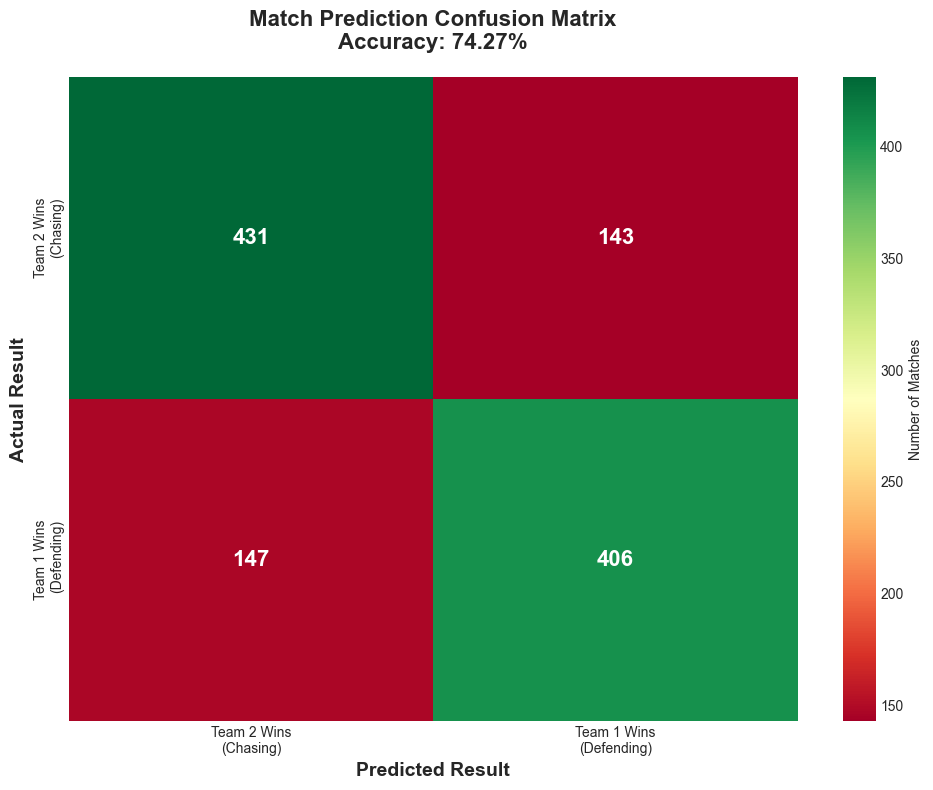


📊 Prediction Breakdown:
   ✅ Correct Predictions: 837 / 1127
   ❌ Incorrect Predictions: 290 / 1127

   True Negatives (Correctly predicted Team 2 wins): 431
   False Positives (Wrongly predicted Team 1 wins): 143
   False Negatives (Wrongly predicted Team 2 wins): 147
   True Positives (Correctly predicted Team 1 wins): 406


In [7]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn', 
            annot_kws={'size': 16, 'weight': 'bold'},
            cbar_kws={'label': 'Number of Matches'},
            xticklabels=['Team 2 Wins\n(Chasing)', 'Team 1 Wins\n(Defending)'],
            yticklabels=['Team 2 Wins\n(Chasing)', 'Team 1 Wins\n(Defending)'])

plt.title(f'Match Prediction Confusion Matrix\nAccuracy: {accuracy*100:.2f}%', 
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Actual Result', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Result', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n📊 Prediction Breakdown:")
print(f"   ✅ Correct Predictions: {cm[0,0] + cm[1,1]} / {len(y_test)}")
print(f"   ❌ Incorrect Predictions: {cm[0,1] + cm[1,0]} / {len(y_test)}")
print(f"\n   True Negatives (Correctly predicted Team 2 wins): {cm[0,0]}")
print(f"   False Positives (Wrongly predicted Team 1 wins): {cm[0,1]}")
print(f"   False Negatives (Wrongly predicted Team 2 wins): {cm[1,0]}")
print(f"   True Positives (Correctly predicted Team 1 wins): {cm[1,1]}")

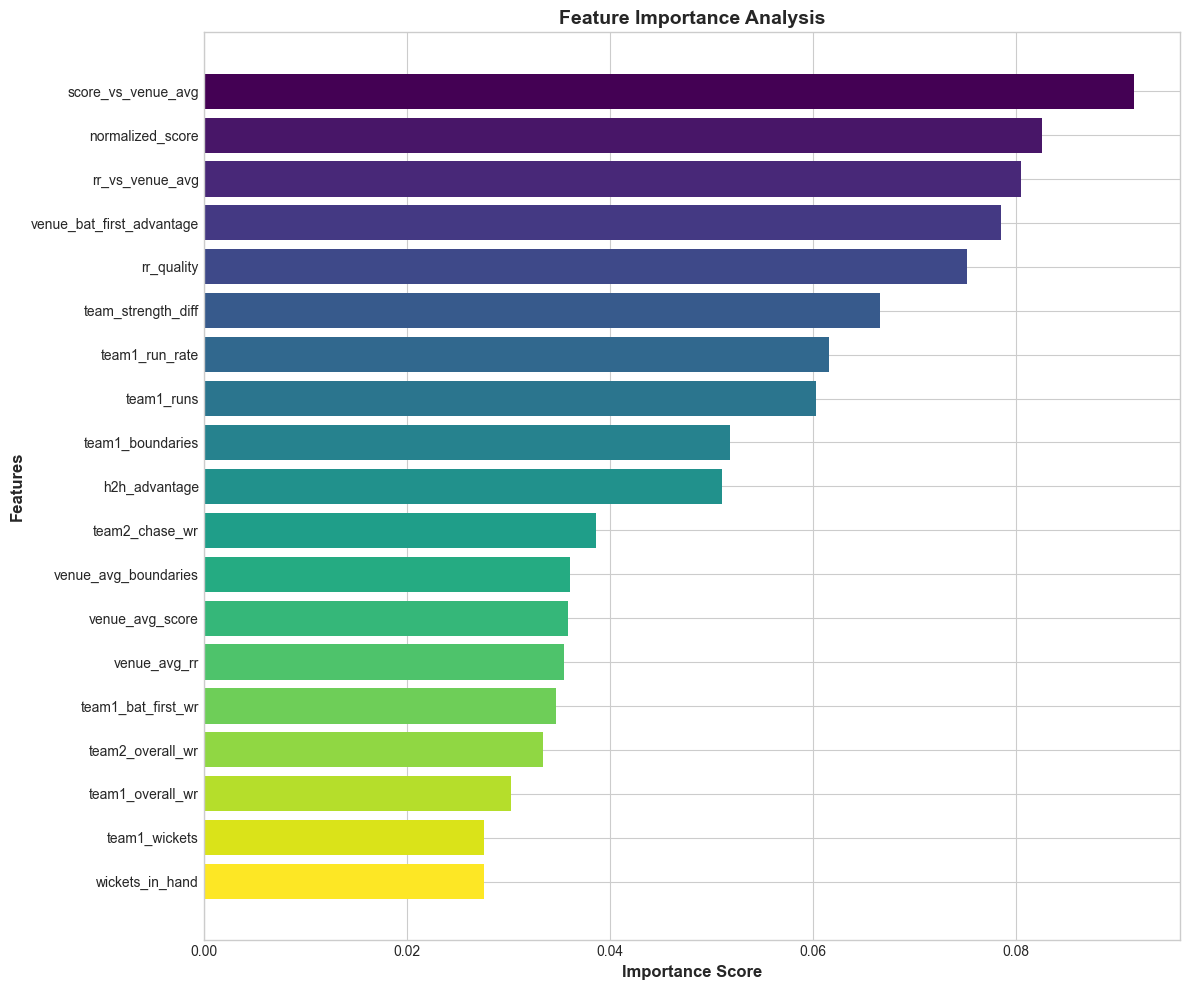


🔝 Top 10 Most Important Features:
score_vs_venue_avg            : 0.0916
normalized_score              : 0.0826
rr_vs_venue_avg               : 0.0806
venue_bat_first_advantage     : 0.0785
rr_quality                    : 0.0752
team_strength_diff            : 0.0667
team1_run_rate                : 0.0616
team1_runs                    : 0.0603
team1_boundaries              : 0.0519
h2h_advantage                 : 0.0511


In [8]:
# Get feature importance from Random Forest
rf.fit(X_train, y_train)
importance = pd.DataFrame({
    'feature': features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 10))
colors = plt.cm.viridis(np.linspace(0, 1, len(importance)))
bars = plt.barh(importance['feature'], importance['importance'], color=colors)
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title('Feature Importance Analysis', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n🔝 Top 10 Most Important Features:")
print("="*60)
for i, row in importance.head(10).iterrows():
    print(f"{row['feature']:30s}: {row['importance']:.4f}")

In [9]:
# Cross-validation for reliability
print("\n🔄 Performing 5-Fold Cross-Validation...")
print("="*70)

cv_scores = cross_val_score(ensemble, X, y, cv=5, scoring='accuracy', n_jobs=-1)

print(f"\nCross-Validation Scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"   Fold {i}: {score*100:.2f}%")

print(f"\n📊 Mean CV Accuracy: {cv_scores.mean()*100:.2f}% (±{cv_scores.std()*100:.2f}%)")
print(f"✅ Model is {'RELIABLE' if cv_scores.std() < 0.05 else 'VARIABLE'}")


🔄 Performing 5-Fold Cross-Validation...

Cross-Validation Scores:
   Fold 1: 76.38%
   Fold 2: 77.78%
   Fold 3: 69.06%
   Fold 4: 74.23%
   Fold 5: 75.03%

📊 Mean CV Accuracy: 74.50% (±2.97%)
✅ Model is RELIABLE


In [10]:
import os
os.makedirs('../models', exist_ok=True)

# Save ensemble model
with open('../models/ultimate_ensemble_model.pkl', 'wb') as f:
    pickle.dump(ensemble, f)
print("✅ Model saved: ultimate_ensemble_model.pkl")

# Save team stats
with open('../models/team_statistics.pkl', 'wb') as f:
    pickle.dump(team_stats, f)
print("✅ Team stats saved")

# Save venue stats
venue_stats.to_csv('../data/processed/venue_statistics_complete.csv', index=False)
print("✅ Venue stats saved")

# Save feature list
model_info = {
    'features': features,
    'accuracy': accuracy,
    'auc': auc,
    'cv_mean': cv_scores.mean(),
    'cv_std': cv_scores.std()
}

with open('../models/model_info.pkl', 'wb') as f:
    pickle.dump(model_info, f)
print("✅ Model info saved")

print("\n" + "="*70)
print("🎉 MODEL TRAINING COMPLETE!")
print("="*70)
print(f"✅ Final Accuracy: {accuracy*100:.2f}%")


✅ Model saved: ultimate_ensemble_model.pkl
✅ Team stats saved
✅ Venue stats saved
✅ Model info saved

🎉 MODEL TRAINING COMPLETE!
✅ Final Accuracy: 74.27%


In [11]:
def predict_match_simple(team1_runs, team1_wickets, team1_run_rate, 
                        team1_name, team2_name, venue_name):
    """
    SIMPLE PREDICTION FUNCTION - Only needs 6 inputs!
    
    INPUTS:
    - team1_runs: Runs scored by batting team (e.g., 185)
    - team1_wickets: Wickets lost (e.g., 6)
    - team1_run_rate: Current run rate (e.g., 9.25)
    - team1_name: Name of batting team (e.g., 'India')
    - team2_name: Name of chasing team (e.g., 'Australia')
    - venue_name: Ground name (e.g., 'Wankhede Stadium, Mumbai')
    
    RETURNS: Prediction with probability
    """
    
    # Get team stats from database
    t1_stats = team_stats.get(team1_name, {
        'overall_win_rate': 0.5,
        'bat_first_win_rate': 0.5,
        'avg_score': 150,
        'avg_run_rate': 6.0
    })
    
    t2_stats = team_stats.get(team2_name, {
        'overall_win_rate': 0.5,
        'chase_win_rate': 0.5
    })
    
    # Get venue stats from database
    venue_row = venue_stats[venue_stats['venue'] == venue_name]
    
    if len(venue_row) > 0:
        venue_avg_score = venue_row['venue_avg_score'].values[0]
        venue_bat_first_adv = venue_row['venue_bat_first_advantage'].values[0]
        venue_avg_rr = venue_row['venue_avg_rr'].values[0]
        venue_avg_boundaries = venue_row['venue_avg_boundaries'].values[0]
    else:
        # Default values if venue not found
        venue_avg_score = 165
        venue_bat_first_adv = 0.5
        venue_avg_rr = 7.0
        venue_avg_boundaries = 16
    
    # Estimate boundaries from runs (rough estimate: 1 boundary per 10 runs)
    estimated_boundaries = int(team1_runs / 10)
    
    # Calculate derived features
    team_strength_diff = t1_stats['overall_win_rate'] - t2_stats['overall_win_rate']
    score_vs_venue_avg = team1_runs - venue_avg_score
    rr_vs_venue_avg = team1_run_rate - venue_avg_rr
    wickets_in_hand = 10 - team1_wickets
    rr_quality = team1_run_rate - t1_stats['avg_run_rate']
    
    # Determine format based on score
    if team1_runs > 250:
        match_format = 'ODI'
        normalized_score = team1_runs / 200
    else:
        match_format = 'T20'
        normalized_score = team1_runs / 160
    
    # Get h2h advantage
    h2h_key = tuple(sorted([team1_name, team2_name]))
    h2h_adv = 0.5  # Default if no history
    
    # Create input dataframe
    user_input = pd.DataFrame({
        'team1_runs': [team1_runs],
        'team1_wickets': [team1_wickets],
        'team1_run_rate': [team1_run_rate],
        'team1_overall_wr': [t1_stats['overall_win_rate']],
        'team2_overall_wr': [t2_stats['overall_win_rate']],
        'team1_bat_first_wr': [t1_stats['bat_first_win_rate']],
        'team2_chase_wr': [t2_stats['chase_win_rate']],
        'team_strength_diff': [team_strength_diff],
        'h2h_advantage': [h2h_adv],
        'venue_avg_score': [venue_avg_score],
        'venue_bat_first_advantage': [venue_bat_first_adv],
        'venue_avg_rr': [venue_avg_rr],
        'venue_avg_boundaries': [venue_avg_boundaries],
        'team1_boundaries': [estimated_boundaries],
        'score_vs_venue_avg': [score_vs_venue_avg],
        'rr_vs_venue_avg': [rr_vs_venue_avg],
        'wickets_in_hand': [wickets_in_hand],
        'rr_quality': [rr_quality],
        'normalized_score': [normalized_score]
    })
    
    # Predict
    prediction = ensemble.predict(user_input)[0]
    probability = ensemble.predict_proba(user_input)[0]
    
    # Return results
    return {
        'match_format': match_format,
        'team1': team1_name,
        'team2': team2_name,
        'venue': venue_name,
        'team1_score': f"{team1_runs}/{team1_wickets}",
        'run_rate': team1_run_rate,
        'prediction': f"{team1_name} wins!" if prediction == 1 else f"{team2_name} wins!",
        'team1_win_probability': round(probability[1] * 100, 2),
        'team2_win_probability': round(probability[0] * 100, 2),
        'confidence': 'High' if max(probability) > 0.75 else 'Moderate' if max(probability) > 0.60 else 'Low',
        'venue_avg_score': round(venue_avg_score, 1),
        'venue_advantage': 'Batting First' if venue_bat_first_adv > 0.5 else 'Chasing'
    }

print("✅ Simple prediction function created!")
print("\n📝 Usage:")
print("result = predict_match_simple(185, 6, 9.25, 'India', 'Australia', 'Wankhede Stadium, Mumbai')")

✅ Simple prediction function created!

📝 Usage:
result = predict_match_simple(185, 6, 9.25, 'India', 'Australia', 'Wankhede Stadium, Mumbai')


In [12]:
print("🎮 TESTING MODEL WITH SAMPLE INPUTS")
print("="*70)

# TEST 1: High-scoring T20 match
print("\n📋 TEST 1: High-scoring T20 Match")
print("-" * 70)
result1 = predict_match_simple(
    team1_runs=195,
    team1_wickets=5,
    team1_run_rate=9.75,
    team1_name='India',
    team2_name='England',
    venue_name='Eden Gardens, Kolkata'
)

print(f"Match Format: {result1['match_format']}")
print(f"Teams: {result1['team1']} vs {result1['team2']}")
print(f"Venue: {result1['venue']}")
print(f"Team 1 Score: {result1['team1_score']} (RR: {result1['run_rate']})")
print(f"\n🎯 PREDICTION: {result1['prediction']}")
print(f"   {result1['team1']} Win Probability: {result1['team1_win_probability']}%")
print(f"   {result1['team2']} Win Probability: {result1['team2_win_probability']}%")
print(f"   Confidence: {result1['confidence']}")
print(f"\n📊 Venue Stats:")
print(f"   Average Score: {result1['venue_avg_score']}")
print(f"   Advantage: {result1['venue_advantage']}")

# TEST 2: Low-scoring T20 match
print("\n" + "="*70)
print("📋 TEST 2: Low-scoring T20 Match")
print("-" * 70)
result2 = predict_match_simple(
    team1_runs=142,
    team1_wickets=8,
    team1_run_rate=7.10,
    team1_name='Pakistan',
    team2_name='South Africa',
    venue_name='Dubai International Cricket Stadium'
)

print(f"Match Format: {result2['match_format']}")
print(f"Teams: {result2['team1']} vs {result2['team2']}")
print(f"Venue: {result2['venue']}")
print(f"Team 1 Score: {result2['team1_score']} (RR: {result2['run_rate']})")
print(f"\n🎯 PREDICTION: {result2['prediction']}")
print(f"   {result2['team1']} Win Probability: {result2['team1_win_probability']}%")
print(f"   {result2['team2']} Win Probability: {result2['team2_win_probability']}%")
print(f"   Confidence: {result2['confidence']}")

# TEST 3: ODI Match
print("\n" + "="*70)
print("📋 TEST 3: ODI Match")
print("-" * 70)
result3 = predict_match_simple(
    team1_runs=287,
    team1_wickets=7,
    team1_run_rate=5.74,
    team1_name='Australia',
    team2_name='New Zealand',
    venue_name='Melbourne Cricket Ground'
)

print(f"Match Format: {result3['match_format']}")
print(f"Teams: {result3['team1']} vs {result3['team2']}")
print(f"Venue: {result3['venue']}")
print(f"Team 1 Score: {result3['team1_score']} (RR: {result3['run_rate']})")
print(f"\n🎯 PREDICTION: {result3['prediction']}")
print(f"   {result3['team1']} Win Probability: {result3['team1_win_probability']}%")
print(f"   {result3['team2']} Win Probability: {result3['team2_win_probability']}%")
print(f"   Confidence: {result3['confidence']}")

# TEST 4: Close match
print("\n" + "="*70)
print("📋 TEST 4: Close T20 Match")
print("-" * 70)
result4 = predict_match_simple(
    team1_runs=168,
    team1_wickets=7,
    team1_run_rate=8.40,
    team1_name='West Indies',
    team2_name='Sri Lanka',
    venue_name='Queens Park Oval, Port of Spain'
)

print(f"Match Format: {result4['match_format']}")
print(f"Teams: {result4['team1']} vs {result4['team2']}")
print(f"Venue: {result4['venue']}")
print(f"Team 1 Score: {result4['team1_score']} (RR: {result4['run_rate']})")
print(f"\n🎯 PREDICTION: {result4['prediction']}")
print(f"   {result4['team1']} Win Probability: {result4['team1_win_probability']}%")
print(f"   {result4['team2']} Win Probability: {result4['team2_win_probability']}%")
print(f"   Confidence: {result4['confidence']}")

print("\n" + "="*70)
print("✅ ALL TESTS COMPLETED!")
print("="*70)

🎮 TESTING MODEL WITH SAMPLE INPUTS

📋 TEST 1: High-scoring T20 Match
----------------------------------------------------------------------
Match Format: T20
Teams: India vs England
Venue: Eden Gardens, Kolkata
Team 1 Score: 195/5 (RR: 9.75)

🎯 PREDICTION: India wins!
   India Win Probability: 67.13%
   England Win Probability: 32.87%
   Confidence: Moderate

📊 Venue Stats:
   Average Score: 198.9
   Advantage: Batting First

📋 TEST 2: Low-scoring T20 Match
----------------------------------------------------------------------
Match Format: T20
Teams: Pakistan vs South Africa
Venue: Dubai International Cricket Stadium
Team 1 Score: 142/8 (RR: 7.1)

🎯 PREDICTION: South Africa wins!
   Pakistan Win Probability: 27.23%
   South Africa Win Probability: 72.77%
   Confidence: Moderate

📋 TEST 3: ODI Match
----------------------------------------------------------------------
Match Format: ODI
Teams: Australia vs New Zealand
Venue: Melbourne Cricket Ground
Team 1 Score: 287/7 (RR: 5.74)

🎯 PR

In [13]:
# Get list of all teams
print("🏏 AVAILABLE TEAMS IN DATABASE:")
print("="*70)

all_teams = sorted(pd.concat([matches['team1'], matches['team2']]).unique())

print(f"\nTotal Teams: {len(all_teams)}")
print("\nTeam List:")
for i, team in enumerate(all_teams, 1):
    team_matches = len(matches[(matches['team1'] == team) | (matches['team2'] == team)])
    print(f"{i:3d}. {team:40s} ({team_matches:3d} matches)")

# Get list of all venues
print("\n" + "="*70)
print("🌍 AVAILABLE VENUES IN DATABASE:")
print("="*70)

all_venues = matches['venue'].value_counts()

print(f"\nTotal Venues: {len(all_venues)}")
print("\nTop 30 Most Used Venues:")
for i, (venue, count) in enumerate(all_venues.head(30).items(), 1):
    avg_score = matches[matches['venue'] == venue]['team1_runs'].mean()
    bat_first_wr = matches[matches['venue'] == venue]['team1_won'].mean()
    print(f"{i:3d}. {venue:50s} | {count:3d} matches | Avg: {avg_score:.0f} | Bat 1st: {bat_first_wr*100:.0f}%")

# Save lists for easy access
team_list = pd.DataFrame({'team_name': all_teams})
team_list.to_csv('../data/processed/team_list.csv', index=False)

venue_list = pd.DataFrame({
    'venue_name': all_venues.index,
    'matches_played': all_venues.values
})
venue_list.to_csv('../data/processed/venue_list.csv', index=False)

print("\n✅ Team and venue lists saved to CSV files!")

🏏 AVAILABLE TEAMS IN DATABASE:

Total Teams: 125

Team List:
  1. Africa XI                                (  4 matches)
  2. Argentina                                ( 19 matches)
  3. Asia XI                                  (  4 matches)
  4. Australia                                (865 matches)
  5. Austria                                  ( 57 matches)
  6. Bahamas                                  ( 18 matches)
  7. Bahrain                                  ( 91 matches)
  8. Bangladesh                               (573 matches)
  9. Barbados                                 (  1 matches)
 10. Belgium                                  ( 36 matches)
 11. Belize                                   (  9 matches)
 12. Bermuda                                  ( 44 matches)
 13. Bhutan                                   ( 32 matches)
 14. Botswana                                 ( 52 matches)
 15. Brazil                                   ( 12 matches)
 16. Bulgaria                          